# 基于特征匹配的知识蒸馏（SAGAN CcGAN）

1. **Teacher**：加载原先 `gene_ch=64` 的预训练生成器，添加一个 `forward_with_feats` 方法获取中间层特征。
2. **Student**：将 `gene_ch=32`，结构保持相似，但通道数减半。也实现 `forward_with_feats`。
3. **特征对齐（1×1 卷积）**：因为 Teacher / Student 的通道数不同，需要对学生特征进行通道映射再和 Teacher 的特征做 MSE (或 L1) 对比。
4. **训练循环**：以随机噪声 + 标签输入，Teacher 特征作为"暗知识"，让 Student 学到相似的特征表示，实现模型压缩。

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from torch.nn.init import xavier_uniform_
from torch.nn.utils import spectral_norm
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 封装一个带谱归一化的卷积层
def snconv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
    return spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size,
                                   stride, padding, dilation, groups, bias))

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.)

# 封装一个带谱归一化的全连接层
def snlinear(in_features, out_features, bias=True):
    return spectral_norm(nn.Linear(in_features=in_features, out_features=out_features, bias=bias))



def feature_distill_loss(feats_student, feats_teacher, adapters):
    """
    feats_student/feats_teacher: list of feature maps
    adapters: 对应层的 1x1 conv 列表
    """
    loss = 0.0
    for i, (fs, ft) in enumerate(zip(feats_student, feats_teacher)):
        fs_aligned = adapters[i](fs)
        loss_i = F.mse_loss(fs_aligned, ft)
        loss += loss_i
    return loss / len(feats_student)

def visualize_results(images: torch.Tensor, nrows: int = 1, ncols: int = 4) -> None:
    """
    可视化给定的图像张量列表/批次。将图像数据从张量转换为图片进行展示。
    参数:
        images: 形状为 (B,C,H,W) 的图像张量，C=3 表示 RGB 图像。
        nrows, ncols: 网格展示的行数和列数。
    """
    # 将图像数据搬到CPU并转换到 [0,1] 区间
    imgs = images.clone().detach().cpu()
    # 如果像素值在 [-1,1]，转换到 [0,1]
    if imgs.min() < 0:
        imgs = (imgs + 1.0) / 2.0  # [-1,1] -> [0,1]
    imgs = imgs.clamp(0.0, 1.0)   # 截断确保在 [0,1]

    # 将批次图像拆分，逐个绘制
    batch_size = imgs.shape[0]
    fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
    # 如果只有一行，axes 可能不是二维数组
    if nrows == 1:
        axes = [axes]  # 保证axes可迭代
    idx = 0
    for i in range(nrows):
        for j in range(ncols):
            if idx < batch_size:
                img = imgs[idx].permute(1, 2, 0).numpy()  # (H,W,C)
                axes[i][j].imshow(img)
                axes[i][j].axis("off")
                idx += 1
            else:
                axes[i][j].axis("off")
    plt.show()


class FeatureAdapter(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FeatureAdapter, self).__init__()
        # 如果通道一致，就 Identity；不一致才用1x1卷积
        if in_channels == out_channels:
            self.adapter = nn.Identity()
        else:
            self.adapter = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
    def forward(self, x):
        return self.adapter(x)



Using device: cuda


In [2]:
class Self_Attn(nn.Module):
    def __init__(self, in_channels):
        super(Self_Attn, self).__init__()
        self.in_channels = in_channels
        self.snconv1x1_theta = snconv2d(in_channels, in_channels // 8, kernel_size=1)
        self.snconv1x1_phi = snconv2d(in_channels, in_channels // 8, kernel_size=1)
        self.snconv1x1_g = snconv2d(in_channels, in_channels // 2, kernel_size=1)
        self.snconv1x1_attn = snconv2d(in_channels // 2, in_channels, kernel_size=1)
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.softmax  = nn.Softmax(dim=-1)
        self.sigma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, ch, h, w = x.size()
        theta = self.snconv1x1_theta(x).view(B, ch//8, h*w)
        phi = self.snconv1x1_phi(x)
        phi = self.maxpool(phi).view(B, ch//8, h*w//4)
        attn = self.softmax(torch.bmm(theta.permute(0, 2, 1), phi))
        g = self.snconv1x1_g(x)
        g = self.maxpool(g).view(B, ch//2, h*w//4)
        attn_g = torch.bmm(g, attn.permute(0, 2, 1)).view(B, ch//2, h, w)
        attn_g = self.snconv1x1_attn(attn_g)
        return x + self.sigma * attn_g

class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, dim_embed):
        """
        参数：
            num_features: 输入特征图通道数
            dim_embed: 标签嵌入维度
        """
        super().__init__()
        self.num_features = num_features
        # 标准批归一化，但不使用可学习参数（affine=False）
        self.bn = nn.BatchNorm2d(num_features, momentum=0.001, affine=False)
        # 两个全连接层分别映射标签嵌入到gamma和beta
        self.embed_gamma = nn.Linear(dim_embed, num_features, bias=False)
        self.embed_beta = nn.Linear(dim_embed, num_features, bias=False)

    def forward(self, x, y):
        """
        输入：
            x: 特征图 (B, C, H, W)
            y: 标签嵌入 (B, dim_embed)
        输出：
            条件归一化后的特征图
        """
        out = self.bn(x)
        # 计算缩放因子gamma和偏置beta，并reshape为 (B, C, 1, 1)
        gamma = self.embed_gamma(y).view(-1, self.num_features, 1, 1)
        beta = self.embed_beta(y).view(-1, self.num_features, 1, 1)
        # 采用公式：out = bn(x) + gamma * bn(x) + beta
        out = out + gamma * out + beta
        return out

class GenBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dim_embed):
        """
        参数：
            in_channels: 输入通道数
            out_channels: 输出通道数
            dim_embed: 标签嵌入维度
        """
        super(GenBlock, self).__init__()
        self.cond_bn1 = ConditionalBatchNorm2d(in_channels, dim_embed)
        self.relu = nn.ReLU(inplace=True)
        # 第一个卷积层，采用谱归一化
        self.snconv2d1 = snconv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.cond_bn2 = ConditionalBatchNorm2d(out_channels, dim_embed)
        # 第二个卷积层
        self.snconv2d2 = snconv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        # 用于旁路连接的1x1卷积，调整通道数
        self.snconv2d0 = snconv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, labels):
        """
        前向传播：
            x: 输入特征图 (B, in_channels, H, W)
            labels: 标签嵌入 (B, dim_embed)
        输出：
            输出特征图 (B, out_channels, 2H, 2W) —— 经过上采样后尺寸加倍
        """
        x0 = x  # 旁路分支保存原始输入

        # 主分支：先条件归一化，再ReLU激活，然后上采样
        x = self.cond_bn1(x, labels)
        x = self.relu(x)
        x = F.interpolate(x, scale_factor=2, mode='nearest')  # 上采样（nearest插值）
        x = self.snconv2d1(x)  # 进行卷积
        x = self.cond_bn2(x, labels)
        x = self.relu(x)
        x = self.snconv2d2(x)  # 第二次卷积

        # 旁路分支：对原始输入进行上采样和1x1卷积
        x0 = F.interpolate(x0, scale_factor=2, mode='nearest')
        x0 = self.snconv2d0(x0)

        # 将主分支和旁路分支相加得到最终输出
        out = x + x0
        return out


class CcGAN_SAGAN_Generator_Teacher(nn.Module):
    def __init__(self, dim_z, dim_embed=128, nc=3, gene_ch=64):
        super(CcGAN_SAGAN_Generator_Teacher, self).__init__()
        self.dim_z = dim_z
        self.gene_ch = gene_ch
        self.snlinear0 = snlinear(dim_z, gene_ch*16*4*4)
        self.block1 = GenBlock(gene_ch*16, gene_ch*8, dim_embed)
        self.block2 = GenBlock(gene_ch*8, gene_ch*4, dim_embed)
        self.block3 = GenBlock(gene_ch*4, gene_ch*2, dim_embed)
        self.self_attn = Self_Attn(gene_ch*2)
        self.block4 = GenBlock(gene_ch*2, gene_ch, dim_embed)
        self.bn = nn.BatchNorm2d(gene_ch, eps=1e-5, momentum=0.0001, affine=True)
        self.relu = nn.ReLU(inplace=True)
        self.snconv2d1 = snconv2d(gene_ch, nc, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()
        self.apply(init_weights)

    def forward(self, z, labels, return_features=True):
        features = {}
        out = self.snlinear0(z)
        out = out.view(-1, self.gene_ch*16, 4, 4)
        features['fc'] = out
        out = self.block1(out, labels)
        features['block1'] = out
        out = self.block2(out, labels)
        features['block2'] = out
        out = self.block3(out, labels)
        features['block3'] = out
        out = self.self_attn(out)
        features['attn'] = out
        out = self.block4(out, labels)
        features['block4'] = out
        out = self.bn(out)
        out = self.relu(out)
        out = self.snconv2d1(out)
        features['conv'] = out
        out = self.tanh(out)
        features['tanh'] = out
        if return_features:
            return out, features
        else:
            return out
# 归一化特征，避免数值过大，并对齐维度
def normalize_feature(feat, target_shape=None):
    feat = (feat - feat.mean()) / (feat.std() + 1e-8)  # 归一化
    if target_shape:
        feat = F.adaptive_avg_pool2d(feat, target_shape)  # 调整到相同维度
    return feat


In [ ]:
checkpoint = torch.load('C:\\Users\\weiho\\Desktop\\finaldesign\\CcGAN_tutorial\\CcGAN_tutorial\\RC49\\CcGAN\\ckpt_niter_30000.pth')

state_dict = checkpoint['netG_state_dict']

# 移除 "module." 前缀
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("module.", "")
    new_state_dict[new_key] = v

teacherG = CcGAN_SAGAN_Generator_Teacher(dim_z=256, gene_ch=64).to(device)
teacherG.to(device)
teacherG.load_state_dict(new_state_dict, strict=False)  # 允许部分匹配
teacherG.eval()
for p in teacherG.parameters():
    p.requires_grad = False

print("[Teacher] SAGAN generator (gene_ch=64) loaded & ready.")
#print(teacherG)


[Teacher] SAGAN generator (gene_ch=64) loaded & ready.


In [4]:
# 学生模型
class CcGAN_SAGAN_Generator_Student(nn.Module):
    def __init__(self, dim_z, dim_embed=128, nc=3, gene_ch=32):
        super(CcGAN_SAGAN_Generator_Student, self).__init__()
        self.dim_z = dim_z
        self.gene_ch = gene_ch
        self.snlinear0 = snlinear(dim_z, gene_ch*16*4*4)
        self.block1 = GenBlock(gene_ch*16, gene_ch*8, dim_embed)
        self.block2 = GenBlock(gene_ch*8, gene_ch*4, dim_embed)
        self.block3 = GenBlock(gene_ch*4, gene_ch*2, dim_embed)
        self.self_attn = Self_Attn(gene_ch*2)
        self.block4 = GenBlock(gene_ch*2, gene_ch, dim_embed)
        self.bn = nn.BatchNorm2d(gene_ch, eps=1e-5, momentum=0.0001, affine=True)
        self.relu = nn.ReLU(inplace=True)
        self.snconv2d1 = snconv2d(gene_ch, nc, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()
        self.apply(init_weights)

    def forward(self, z, labels, return_features=True):
        features = {}
        out = self.snlinear0(z)
        out = out.view(-1, self.gene_ch*16, 4, 4)
        features['fc'] = out
        out = self.block1(out, labels)
        features['block1'] = out
        out = self.block2(out, labels)
        features['block2'] = out
        out = self.block3(out, labels)
        features['block3'] = out
        out = self.self_attn(out)
        features['attn'] = out
        out = self.block4(out, labels)
        features['block4'] = out
        out = self.bn(out)
        out = self.relu(out)
        out = self.snconv2d1(out)
        features['conv'] = out
        out = self.tanh(out)
        features['tanh'] = out
        if return_features:
            return out, features
        else:
            return out



Step 200/32000, FeatLoss=16.171680
Step 400/32000, FeatLoss=15.925766
Step 600/32000, FeatLoss=15.756030
Step 800/32000, FeatLoss=15.711174
Step 1000/32000, FeatLoss=15.834519
Step 1200/32000, FeatLoss=15.677713
Step 1400/32000, FeatLoss=15.088320
Step 1600/32000, FeatLoss=14.987672
Step 1800/32000, FeatLoss=14.766278
Step 2000/32000, FeatLoss=15.424694
Step 2200/32000, FeatLoss=15.566215
Step 2400/32000, FeatLoss=14.674947
Step 2600/32000, FeatLoss=14.775704
Step 2800/32000, FeatLoss=14.042480
Step 3000/32000, FeatLoss=15.294572
Step 3200/32000, FeatLoss=14.698833
Step 3400/32000, FeatLoss=14.424309
Step 3600/32000, FeatLoss=14.495937
Step 3800/32000, FeatLoss=14.966137
Step 4000/32000, FeatLoss=14.680424
Step 4200/32000, FeatLoss=13.627189
Step 4400/32000, FeatLoss=13.385798
Step 4600/32000, FeatLoss=13.651991
Step 4800/32000, FeatLoss=14.096719
Step 5000/32000, FeatLoss=14.018982
Step 5200/32000, FeatLoss=13.179861
Step 5400/32000, FeatLoss=13.785751
Step 5600/32000, FeatLoss=13.743

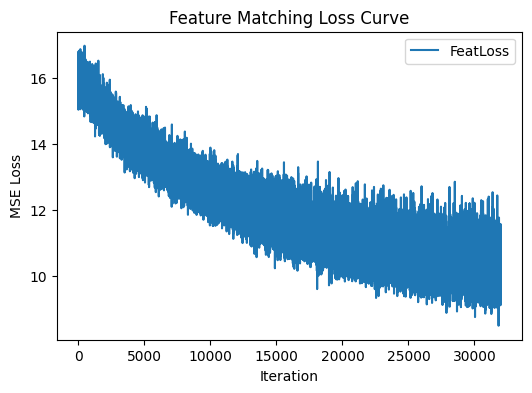

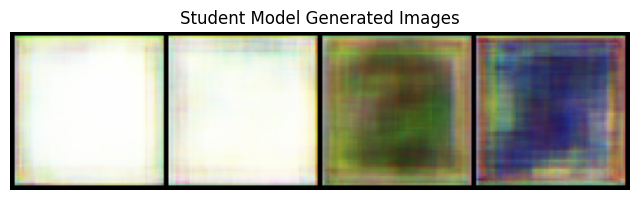

In [5]:
studentG = CcGAN_SAGAN_Generator_Student(dim_z=256, dim_embed=128, gene_ch=32).to(device)
studentG.train()

layers_to_adapt = ["fc", "block1", "block2", "block3", "attn", "block4"]
teacher_c = [1024, 512, 256, 128, 128, 64]
student_c = [512, 256, 128, 64, 64, 32]

adapters_dict = nn.ModuleDict()
for layer, tch_ch, std_ch in zip(layers_to_adapt, teacher_c, student_c):
    adapters_dict[layer] = FeatureAdapter(std_ch, tch_ch).to(device)

# 将学生 + 适配器加入优化器
params_to_opt = list(studentG.parameters()) + list(adapters_dict.parameters())
optimizer = optim.Adam(params_to_opt, lr=1e-6, betas=(0.1, 0.999))

num_steps = 32000
loss_history = []  # 用于记录损失

for step in range(1, num_steps + 1):
    optimizer.zero_grad()

    z = torch.randn(16, 256).to(device)
    y = torch.randn(16, 128).to(device)

    # 提取教师&学生特征
    with torch.no_grad():
        _, teacher_features = teacherG(z, y, return_features=True)
    _, student_features = studentG(z, y, return_features=True)

    # 计算特征匹配损失
    feat_loss = 0.0
    for key in teacher_features.keys():
        # 若key在conv或tanh通道一致(3->3),可选是否蒸馏
        if key in ["conv", "tanh"]:
            t_feat = teacher_features[key]
            s_feat = student_features[key]
            if t_feat.shape[1] == s_feat.shape[1]:
                target_shape = t_feat.shape[-2:]
                t_feat = normalize_feature(t_feat, target_shape)
                s_feat = normalize_feature(s_feat, target_shape)
                feat_loss += F.mse_loss(s_feat, t_feat)
            continue

        # 其他层(前6层)需要适配器
        target_shape = teacher_features[key].shape[-2:]  # (H,W)
        t_feat = normalize_feature(teacher_features[key], target_shape)

        # 用adapters_dict[key]调学生
        s_feat_ = adapters_dict[key](student_features[key])
        s_feat_ = normalize_feature(s_feat_, target_shape)

        feat_loss += F.mse_loss(s_feat_, t_feat)

    feat_loss.backward()
    optimizer.step()

    loss_history.append(feat_loss.item())
    if step % 200 == 0:
        print(f"Step {step}/{num_steps}, FeatLoss={feat_loss.item():.6f}")

# 训练结束, 保存学生模型
save_path = "studentG_distilled_ckpt.pth"
torch.save({
    "studentG_state_dict": studentG.state_dict(),
    "adapters_state_dict": adapters_dict.state_dict(),
    "loss_history": loss_history
}, save_path)
print(f"\n[Info] Training finished, student model saved to {save_path}.")

# 绘制feat_loss变化曲线
plt.figure(figsize=(6,4))
plt.plot(loss_history, label="FeatLoss")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title("Feature Matching Loss Curve")
plt.legend()
plt.show()

studentG.eval()
z_test = torch.randn(4, 256).to(device)
y_test = torch.randn(4, 128).to(device)
with torch.no_grad():
    images_test = studentG(z_test, y_test, return_features=False)
images_test = (images_test + 1)/2
images_test = images_test.clamp(0,1)

grid = make_grid(images_test.cpu(), nrow=4)
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.title("Student Model Generated Images")
plt.show()




